In [1]:
from tensorflow.keras.metrics import CategoricalAccuracy
import tensorflow as tf
from data_loader import get_loader
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import numpy as np
from models.distances import Euclidean_Distance
from models.stn import BilinearInterpolation,Localization
from sklearn.neighbors import KNeighborsClassifier
from time import time
import os
from models.metrics import accuracy
from tensorflow.keras.metrics import Mean
from sklearn.metrics.pairwise import euclidean_distances as dist

2023-02-18 22:23:27.927590: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-18 22:23:28.052172: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-18 22:23:28.559990: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/nariman/anaconda3/envs/tf/lib/
2023-02-18 22:23:28.560061: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugi

In [2]:
def standardize(img):
    mean = np.mean(img)
    std = np.std(img)
    return (img - mean) / std

In [3]:
def normalize(img):
    return (img - np.min(img))/(np.max(img) - np.min(img))

In [4]:
loaded_encoder = keras.models.load_model(
    'model_files/best_encoders/densenet_gtsrb2tt100k_encoder.h5',
    custom_objects={'BilinearInterpolation':BilinearInterpolation,'Localization':Localization},compile=True)

2023-02-18 22:23:30.449302: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-18 22:23:30.901412: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9747 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


In [5]:
loader = get_loader('gtsrb2tt100k') 
_,test_generator = loader.get_generator(batch=128,dim=64)

In [17]:
def run_retrieval(model,generator,number_of_averaging_retrieval=50):
    t = iter(generator)
    [Xs,Xq],y = next(t)
    n_cls = len(Xs)
    auc = np.empty((n_cls,1))
    retreival_img = np.empty((n_cls,64,64,3))
    number_of_averaging_retrieval = number_of_averaging_retrieval
    for i in range(n_cls):
        print(f'====retreival class {i+1}====')
        z = model(tf.expand_dims(Xs[i],axis=0))
        IM = []
        D = []
        lab = []
        pb = tf.keras.utils.Progbar(len(generator),verbose=1)
        for data in generator:
            [Xs,Xq],y = data
            Zq = model(Xq)
            for k,zq in enumerate(Zq):
                IM += [Xq[k]]
                #zq = loaded_encoder(tf.expand_dims(x,axis=0))
                D += [dist(zq[None,...],z)[0][0]]
                lab += [y[k]]
            pb.add(1)
        D = np.array(D)
        IM = np.array(IM)
        lab = np.array(lab)
        val,indexes =  tf.nn.top_k(-D,k=number_of_averaging_retrieval,sorted=True)
        y_true = np.expand_dims(to_categorical(i,num_classes=n_cls),axis=0)
        auc[i] = tf.keras.metrics.AUC()(lab[indexes],tf.broadcast_to(y_true,lab[indexes].shape))
        img = IM[indexes]
        retreival_img[i] = tf.reduce_mean(img,axis=0)
    return auc,retreival_img
    

In [8]:
auc,retreival_img = run_retrieval(model=loaded_encoder,generator=test_generator,number_of_averaging_retrieval=50)

====retreival class 1====


2023-02-18 22:24:49.725315: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-02-18 22:24:50.957617: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


93/93 [==============================] - 30s 324ms/step
====retreival class 2====
93/93 [==============================] - 29s 311ms/step
====retreival class 3====
93/93 [==============================] - 29s 310ms/step
====retreival class 4====
93/93 [==============================] - 29s 309ms/step
====retreival class 5====
93/93 [==============================] - 29s 309ms/step
====retreival class 6====
93/93 [==============================] - 29s 309ms/step
====retreival class 7====
93/93 [==============================] - 29s 309ms/step
====retreival class 8====
93/93 [==============================] - 29s 309ms/step
====retreival class 9====
93/93 [==============================] - 30s 318ms/step
====retreival class 10====
93/93 [==============================] - 30s 317ms/step
====retreival class 11====
93/93 [==============================] - 30s 319ms/step
====retreival class 12====
93/93 [==============================] - 29s 317ms/step
====retreival class 13====
93/93 [=====

In [9]:
print(f'Average AUC = {tf.reduce_mean(auc):.4f}')

Average AUC = 0.9231


In [10]:
import matplotlib.pyplot as plt

In [15]:
def plot_multi_line(Xs,size=15,font_size=5,hspace=0.1,row_num = 6,col_num=6):
    fig, axes = plt.subplots(nrows=row_num*2,ncols=col_num,
            figsize=(size,size),subplot_kw={'xticks': [], 'yticks': []})
    n = 0
    for row in range(0,2*row_num,2):
        for col in range(col_num):
            axes[row][col].imshow(normalize(Xs[n]))
            #axes[row][col].set_title(names[n],c="green",size=font_size)
            axes[row+1][col].imshow(normalize(retreival_img[n]))
            n += 1
    plt.tight_layout()
    plt.subplots_adjust(hspace=hspace)
    plt.show()

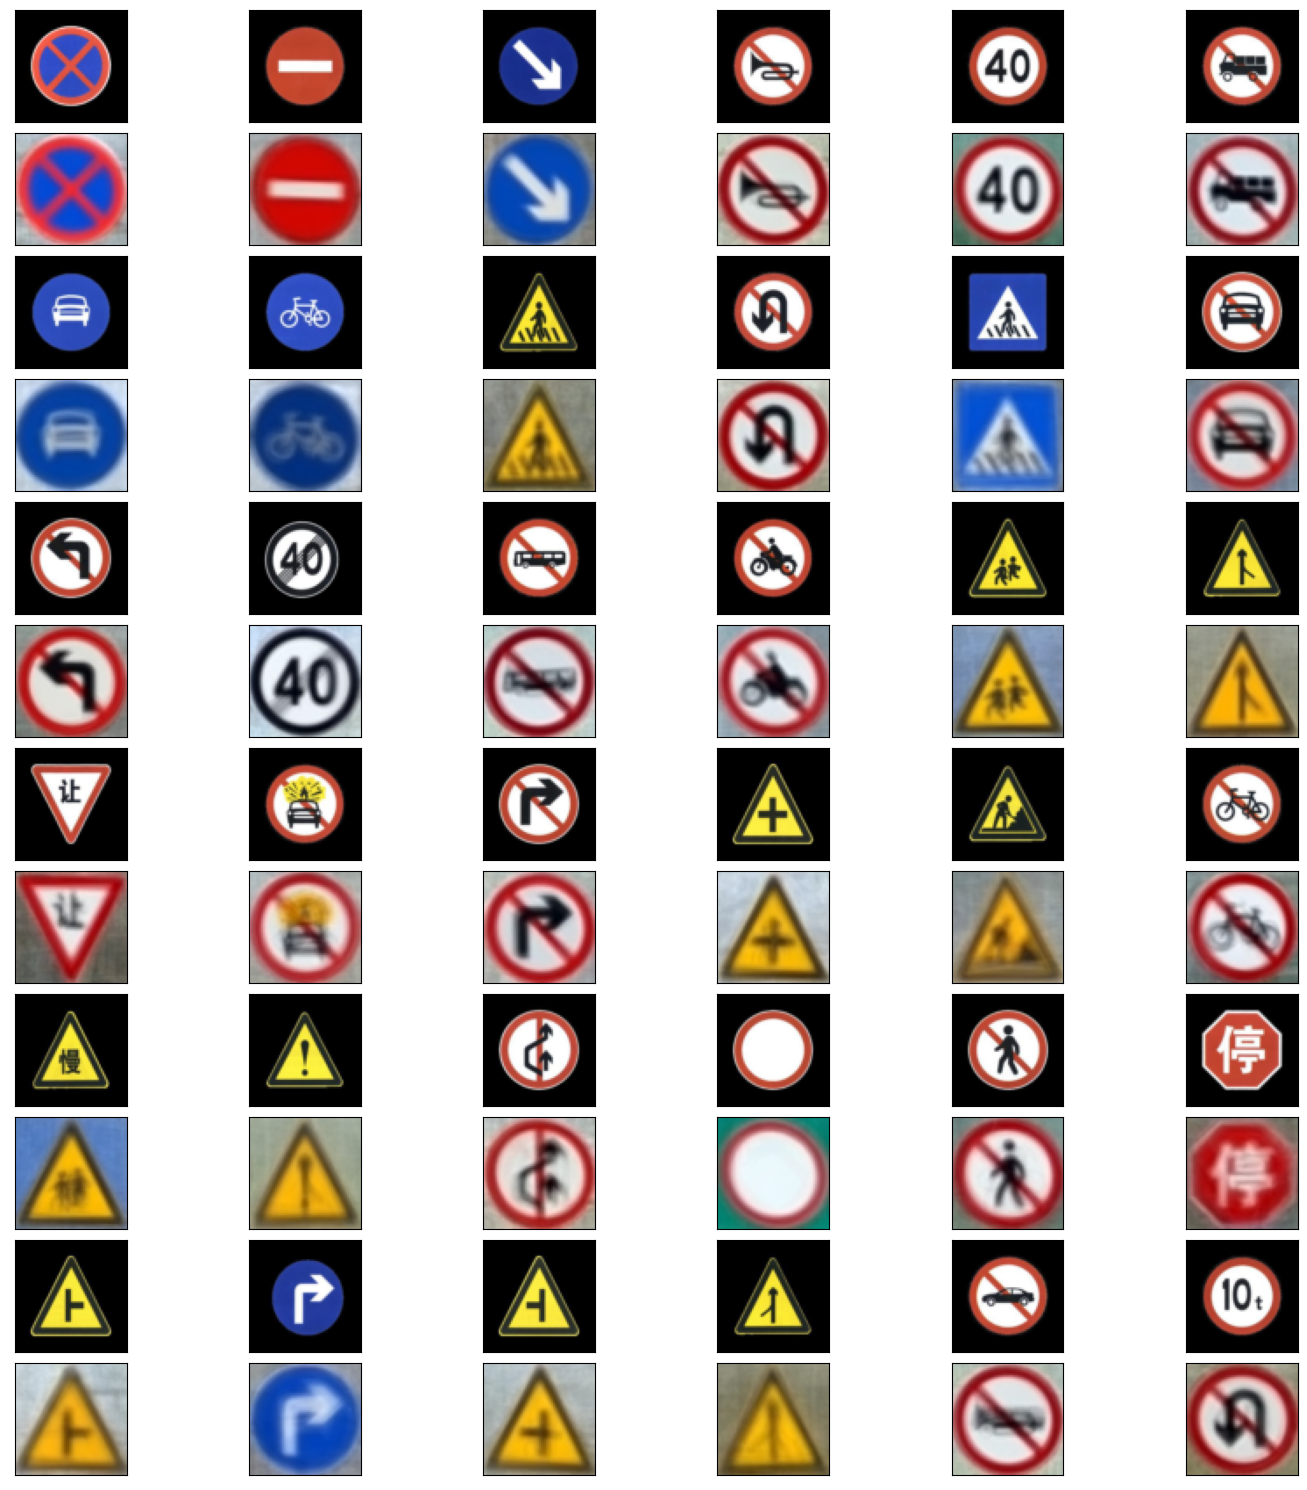

In [16]:
t = iter(test_generator)
[Xs,Xq],y = next(t)
plot_multi_line(Xs)

In [22]:
loaded_encoder = keras.models.load_model(
    'model_files/best_encoders/densenet_belga2flick_encoder.h5',
    custom_objects={'BilinearInterpolation':BilinearInterpolation,'Localization':Localization},compile=True)
loader = get_loader('belga2flick') 
test_generator = loader.get_test_generator(batch=128,dim=64)

In [25]:
auc,retreival_img = run_retrieval(model = loaded_encoder, generator = test_generator, number_of_averaging_retrieval=50)

====retreival class 1====
26/26 [==============================] - 11s 440ms/step
====retreival class 2====
26/26 [==============================] - 11s 442ms/step
====retreival class 3====
26/26 [==============================] - 12s 444ms/step
====retreival class 4====
26/26 [==============================] - 11s 442ms/step
====retreival class 5====
26/26 [==============================] - 11s 442ms/step
====retreival class 6====
26/26 [==============================] - 12s 444ms/step
====retreival class 7====
26/26 [==============================] - 12s 447ms/step
====retreival class 8====
26/26 [==============================] - 12s 443ms/step
====retreival class 9====
26/26 [==============================] - 12s 444ms/step
====retreival class 10====
26/26 [==============================] - 12s 444ms/step
====retreival class 11====
26/26 [==============================] - 12s 445ms/step
====retreival class 12====
26/26 [==============================] - 11s 440ms/step
====retreival

In [26]:
print(f'Average AUC = {tf.reduce_mean(auc):.4f}')

Average AUC = 0.9381


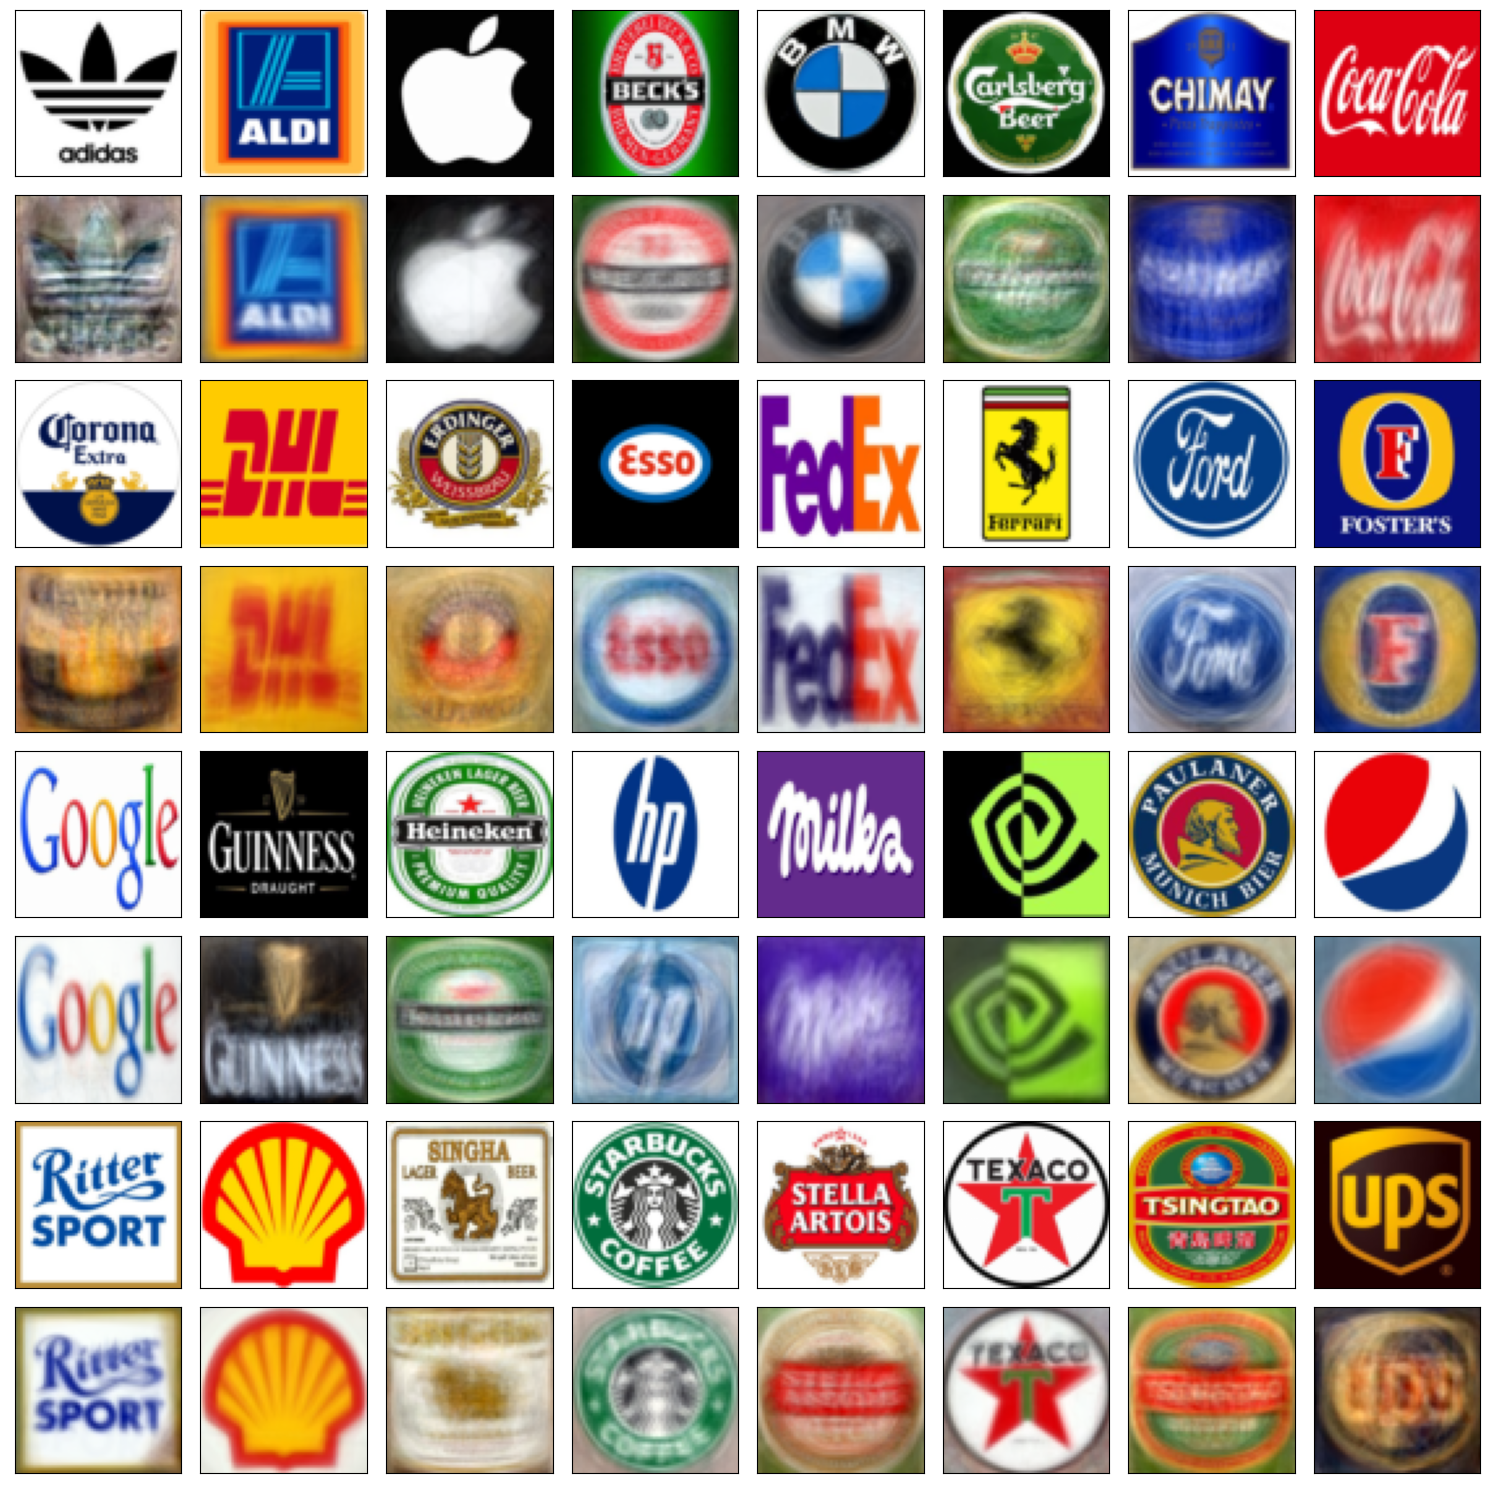

In [29]:
t = iter(test_generator)
[Xs,Xq],y = next(t)
plot_multi_line(Xs,row_num=4,col_num=8)

In [30]:
loaded_encoder = keras.models.load_model(
    'model_files/best_encoders/densenet_belga2toplogo_encoder.h5',
    custom_objects={'BilinearInterpolation':BilinearInterpolation,'Localization':Localization},compile=True)
loader = get_loader('belga2toplogo') 
test_generator = loader.get_test_generator(batch=128,dim=64)

In [37]:
auc,retreival_img = run_retrieval(model = loaded_encoder, generator = test_generator, number_of_averaging_retrieval=50)
print(f'Average AUC = {tf.reduce_mean(auc):.4f}')

====retreival class 1====
6/6 [==============================] - 2s 301ms/step
====retreival class 2====
6/6 [==============================] - 2s 302ms/step
====retreival class 3====
6/6 [==============================] - 2s 303ms/step
====retreival class 4====
6/6 [==============================] - 2s 298ms/step
====retreival class 5====
6/6 [==============================] - 2s 297ms/step
====retreival class 6====
6/6 [==============================] - 2s 295ms/step
====retreival class 7====
6/6 [==============================] - 2s 301ms/step
====retreival class 8====
6/6 [==============================] - 2s 296ms/step
====retreival class 9====
6/6 [==============================] - 2s 295ms/step
====retreival class 10====
6/6 [==============================] - 2s 297ms/step
====retreival class 11====
6/6 [==============================] - 2s 296ms/step
Average AUC = 0.8500


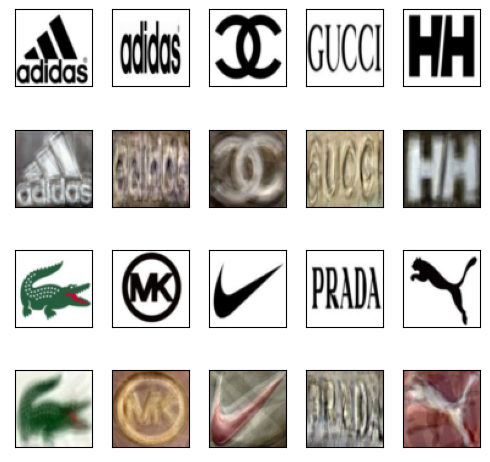

In [36]:
t = iter(test_generator)
[Xs,Xq],y = next(t)
plot_multi_line(Xs,row_num=2,col_num=5,size=5)